In [1]:
import warnings
import logging
import os
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Import Library

In [2]:
import os, sys, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Define Config & Prompt

In [3]:
# ====================CONFIG======================
import random, numpy as np, torch
import unicodedata, re

SEED = 42
BASE_MODEL     = "vinai/phobert-base"
MAX_LEN        = 256
BATCH_SIZE     = 64
NUM_EPOCHS     = 8
LABEL_SMOOTH   = 0.1
CLIP_GRAD_NORM = 1.0
WEIGHT_DECAY   = 3e-4
LR_BACKBONE    = 1e-5
LR_HEAD        = 1e-4
NEG_PER_SENT   = 2

ASPECTS = ["giang_vien", "chuong_trinh", "co_so_vat_chat", "khac"]
ASPECTS_VI = ["giang_vien", "chuong_trinh", "co_so_vat_chat", "khac"]
ASPECTS_EN = ["lecturer", "training_program", "facility", "others"]


def _norm_store(s: str) -> str:
    s = unicodedata.normalize("NFC", str(s)).strip()
    s = re.sub(r"\s+", " ", s)
    return s


def _norm_match(s: str) -> str:
    s = s.lower()
    s = unicodedata.normalize("NFD", s)
    return "".join(ch for ch in s if unicodedata.category(ch) != "Mn")


def _no_diacritics_set(kws: set) -> set:
    return kws | {_norm_match(k) for k in kws}

# ===== PROMPTS =====
ASPECT_PROMPTS = {
    "giang_vien": {
        "_default": (
            "ĐÁNH GIÁ phần liên quan GIẢNG VIÊN (giảng dạy, thái độ, hỗ trợ, chấm điểm, đúng giờ). Nếu câu không nhắc rõ đến GIẢNG VIÊN -> NONE. Mỗi aspect đánh giá độc lập (ví dụ: giảng viên đi dạy trễ nhưng mạng wifi tốt -> giảng viên NEGATIVE, cơ sở vật chất POSITIVE). NEGATIVE khi phàn nàn trễ, khó hiểu, thiếu hỗ trợ; POSITIVE khi được khen đúng giờ, nhiệt tình, dễ hiểu; không rõ -> NEUTRAL."
        ),
        "giang_day": (
            "ĐÁNH GIÁ GIẢNG DẠY của GIẢNG VIÊN. Nếu câu không nói về bài giảng, cách truyền đạt, phương pháp -> NONE. Mỗi aspect độc lập. NEGATIVE khi khó hiểu, quá nhanh/chậm, thiếu ví dụ; POSITIVE khi dễ hiểu, nhiều ví dụ, rõ ràng; không rõ -> NEUTRAL."
        ),
        "dung_gio": (
            "ĐÁNH GIÁ ĐÚNG GIỜ của GIẢNG VIÊN. Nếu câu không nhắc việc vào lớp, bắt đầu/kết thúc tiết -> NONE. Mỗi aspect độc lập. NEGATIVE khi trễ, bỏ tiết; POSITIVE khi đúng giờ, giữ lịch; không rõ -> NEUTRAL."
        ),
        "ho_tro": (
            "ĐÁNH GIÁ HỖ TRỢ/TƯ VẤN của GIẢNG VIÊN. Nếu câu không nhắc hỗ trợ, phản hồi, giải đáp -> NONE. Mỗi aspect độc lập. NEGATIVE khi chậm phản hồi, không giúp; POSITIVE khi nhiệt tình, phản hồi nhanh; không rõ -> NEUTRAL."
        ),
        "cham_diem": (
            "ĐÁNH GIÁ CHẤM ĐIỂM của GIẢNG VIÊN. Nếu câu không nói điểm, rubric, phúc khảo -> NONE. Mỗi aspect độc lập. NEGATIVE khi không công bằng, khó hiểu; POSITIVE khi minh bạch, công bằng; không rõ -> NEUTRAL."
        ),
        "thai_do": (
            "ĐÁNH GIÁ THÁI ĐỘ/TÁC PHONG của GIẢNG VIÊN. Nếu câu không nhắc thái độ, giao tiếp -> NONE. Mỗi aspect độc lập. NEGATIVE khi thô lỗ, thiếu tôn trọng; POSITIVE khi thân thiện, tôn trọng; không rõ -> NEUTRAL."
        ),
    },
    "chuong_trinh": {
        "_default": (
            "ĐÁNH GIÁ CHƯƠNG TRÌNH ĐÀO TẠO (môn học, tín chỉ, nội dung, lộ trình, lịch). Nếu câu không nhắc rõ đến chương trình -> NONE. Mỗi aspect đánh giá độc lập (ví dụ: lịch học dày nhưng giảng viên hỗ trợ tốt -> chương trình NEGATIVE, giảng viên POSITIVE). NEGATIVE khi quá tải, lạc hậu, trùng lặp; POSITIVE khi hợp lý, cập nhật, thực tế; không rõ -> NEUTRAL."
        ),
        "noi_dung": (
            "ĐÁNH GIÁ NỘI DUNG CHƯƠNG TRÌNH. Nếu câu không nói nội dung môn, học liệu, lộ trình -> NONE. Mỗi aspect độc lập. NEGATIVE khi lạc hậu, trùng lặp, thiếu thực tế; POSITIVE khi cập nhật, hữu ích; không rõ -> NEUTRAL."
        ),
        "lich_hoc": (
            "ĐÁNH GIÁ LỊCH HỌC/KẾ HOẠCH. Nếu câu không nhắc lịch, thời khóa biểu, xếp ca -> NONE. Mỗi aspect độc lập. NEGATIVE khi dồn dập, trùng lịch, đổi lịch liên tục; POSITIVE khi rõ ràng, hợp lý; không rõ -> NEUTRAL."
        ),
        "tin_chi": (
            "ĐÁNH GIÁ TÍN CHỈ/HỌC PHẦN. Nếu câu không nói tín chỉ, đăng ký học phần, tiên quyết -> NONE. Mỗi aspect độc lập. NEGATIVE khi bất hợp lý, khó đăng ký; POSITIVE khi phân bổ hợp lý, dễ đăng ký; không rõ -> NEUTRAL."
        ),
        "de_cuong": (
            "ĐÁNH GIÁ ĐỀ CƯƠNG/GIÁO TRÌNH. Nếu câu không nhắc đề cương, tài liệu, rubric -> NONE. Mỗi aspect độc lập. NEGATIVE khi thiếu rõ ràng, thiếu tài liệu; POSITIVE khi đầy đủ, minh bạch; không rõ -> NEUTRAL."
        ),
    },
    "co_so_vat_chat": {
        "_default": (
            "ĐÁNH GIÁ CƠ SỞ VẬT CHẤT (mạng, phòng học, phòng thí nghiệm, thiết bị, thư viện, gửi xe, vệ sinh, cổng đào tạo). Nếu câu không nhắc rõ đến cơ sở vật chất -> NONE. Mỗi aspect đánh giá độc lập (ví dụ: phòng học nóng nhưng thầy cô dạy dễ hiểu -> cơ sở vật chất NEGATIVE, giảng viên POSITIVE). NEGATIVE khi phàn nàn hỏng, thiếu, bẩn; POSITIVE khi khen đầy đủ, sạch, hiện đại; không rõ -> NEUTRAL."
        ),
        "mang": (
            "ĐÁNH GIÁ MẠNG/WI-FI. Nếu câu không nói mạng, wifi, internet -> NONE. Mỗi aspect độc lập. NEGATIVE khi chậm, rớt kết nối; POSITIVE khi nhanh, ổn định; không rõ -> NEUTRAL."
        ),
        "phong_hoc": (
            "ĐÁNH GIÁ PHÒNG HỌC. Nếu câu không nói phòng học, bàn ghế, điều hòa, tiếng ồn -> NONE. Mỗi aspect độc lập. NEGATIVE khi nóng, ồn, xuống cấp; POSITIVE khi mát, sạch, đủ tiện nghi; không rõ -> NEUTRAL."
        ),
        "phong_thi_nghiem": (
            "ĐÁNH GIÁ PHÒNG THÍ NGHIỆM/THỰC HÀNH. Nếu câu không nhắc lab, thiết bị thực hành -> NONE. Mỗi aspect độc lập. NEGATIVE khi thiếu máy, phần mềm lỗi; POSITIVE khi đầy đủ, hiện đại; không rõ -> NEUTRAL."
        ),
        "thiet_bi": (
            "ĐÁNH GIÁ THIẾT BỊ GIẢNG DẠY. Nếu câu không nói máy chiếu, micro, loa, TV -> NONE. Mỗi aspect độc lập. NEGATIVE khi hỏng, âm kém; POSITIVE khi hoạt động tốt, rõ ràng; không rõ -> NEUTRAL."
        ),
        "thu_vien": (
            "ĐÁNH GIÁ THƯ VIỆN. Nếu câu không nhắc thư viện, tài liệu, chỗ ngồi -> NONE. Mỗi aspect độc lập. NEGATIVE khi thiếu tài liệu, chật, ồn; POSITIVE khi phong phú, yên tĩnh; không rõ -> NEUTRAL."
        ),
        "giu_xe_ve_sinh": (
            "ĐÁNH GIÁ GIỮ XE/NHÀ VỆ SINH. Nếu câu không nói gửi xe hoặc nhà vệ sinh -> NONE. Mỗi aspect độc lập. NEGATIVE khi bẩn, đắt, mùi khó chịu; POSITIVE khi sạch, thuận tiện; không rõ -> NEUTRAL."
        ),
        "cong_quan_ly_dao_tao": (
            "ĐÁNH GIÁ CỔNG/TRANG QUẢN LÝ ĐÀO TẠO. Nếu câu không nhắc cổng đào tạo, đăng nhập, tra cứu -> NONE. Mỗi aspect độc lập. NEGATIVE khi quá tải, treo, khó dùng; POSITIVE khi ổn định, dễ dùng; không rõ -> NEUTRAL."
        ),
    },
    "khac": {
        "_default": (
            "ĐÁNH GIÁ NHÓM KHÁC (học phí, học bổng, hành chính, CLB, KTX, một cửa, đăng ký tín chỉ, điểm rèn luyện). Nếu câu không nhắc rõ đến nhóm này -> NONE. Mỗi aspect đánh giá độc lập (ví dụ: học phí tăng nhưng phòng học tốt -> nhóm khác NEGATIVE, cơ sở vật chất POSITIVE). NEGATIVE khi phàn nàn khó khăn, chậm trễ; POSITIVE khi khen rõ ràng, nhanh chóng; không rõ -> NEUTRAL."
        ),
        "hoc_phi": (
            "ĐÁNH GIÁ HỌC PHÍ. Nếu câu không nhắc học phí, mức thu, đóng tiền -> NONE. Mỗi aspect độc lập. NEGATIVE khi đắt, tăng, thiếu minh bạch; POSITIVE khi hợp lý, minh bạch; không rõ -> NEUTRAL."
        ),
        "hoc_bong": (
            "ĐÁNH GIÁ HỌC BỔNG. Nếu câu không nói tiêu chí, quy trình, kết quả học bổng -> NONE. Mỗi aspect độc lập. NEGATIVE khi khó, chậm, không rõ; POSITIVE khi dễ, minh bạch, kịp thời; không rõ -> NEUTRAL."
        ),
        "hanh_chinh": (
            "ĐÁNH GIÁ THỦ TỤC HÀNH CHÍNH/CTSV. Nếu câu không nhắc hồ sơ, giấy tờ, xử lý -> NONE. Mỗi aspect độc lập. NEGATIVE khi rườm rà, chậm, thiếu phản hồi; POSITIVE khi nhanh, rõ ràng; không rõ -> NEUTRAL."
        ),
        "clb": (
            "ĐÁNH GIÁ CLB/HOẠT ĐỘNG NGOẠI KHÓA. Nếu câu không nói CLB, sự kiện, hoạt động sinh viên -> NONE. Mỗi aspect độc lập. NEGATIVE khi ít hoạt động, thiếu hấp dẫn; POSITIVE khi sôi nổi, hữu ích; không rõ -> NEUTRAL."
        ),
        "ktx": (
            "ĐÁNH GIÁ KÝ TÚC XÁ. Nếu câu không nhắc phòng KTX, an ninh, điện nước -> NONE. Mỗi aspect độc lập. NEGATIVE khi chật, mất an ninh, thiếu điện nước; POSITIVE khi sạch, an toàn, đầy đủ; không rõ -> NEUTRAL."
        ),
        "mot_cua": (
            "ĐÁNH GIÁ VĂN PHÒNG MỘT CỬA. Nếu câu không nhắc một cửa, tiếp nhận, trả kết quả -> NONE. Mỗi aspect độc lập. NEGATIVE khi chờ lâu, đông, xử lý chậm; POSITIVE khi nhanh, rõ ràng; không rõ -> NEUTRAL."
        ),
        "dang_ky_tin": (
            "ĐÁNH GIÁ ĐĂNG KÝ TÍN CHỈ. Nếu câu không nói đăng ký môn, hệ thống đăng ký -> NONE. Mỗi aspect độc lập. NEGATIVE khi quá tải, lỗi, khó dùng; POSITIVE khi ổn định, dễ dùng; không rõ -> NEUTRAL."
        ),
        "diem_ren_luyen": (
            "ĐÁNH GIÁ ĐIỂM RÈN LUYỆN. Nếu câu không nhắc DRL, minh chứng, quy trình -> NONE. Mỗi aspect độc lập. NEGATIVE khi khó, không công bằng; POSITIVE khi rõ ràng, công bằng; không rõ -> NEUTRAL."
        ),
    },
}

SUBTOPIC_KW = {
    "giang_vien": {
        "dung_gio": _no_diacritics_set({
            "đi dạy","lên lớp","vào lớp","bắt đầu tiết","kết thúc tiết",
            "giảng viên","giáo viên","thầy giáo","cô giáo","thầy cô",
            "giảng viên đi dạy","giảng viên lên lớp","giảng viên vào lớp",
            "thầy đi dạy","cô đi dạy","thầy lên lớp","cô lên lớp"
        }),
        "cham_diem": _no_diacritics_set({
            "chấm điểm","thang điểm","điểm thi","điểm thành phần","điểm tổng kết","phúc khảo",
            "điểm giữa kỳ","điểm cuối kỳ","điểm nhóm","điểm cá nhân","điểm bonus",
            "điểm chuyên cần","điểm chuyên đề","rubric","grading",
            "giảng viên","giáo viên","thầy giáo","cô giáo",
            "giảng viên chấm điểm","thầy chấm điểm","cô chấm điểm","giáo viên chấm điểm",
            "thầy giáo chấm điểm","cô giáo chấm điểm"
        }),
        "ho_tro": _no_diacritics_set({
            "tư vấn học tập","giải đáp học tập","phản hồi học tập","cvht",
            "cố vấn học tập","hướng dẫn học tập","trao đổi học tập","hỏi đáp học tập",
            "tư vấn sinh viên","giải đáp sinh viên","phản hồi sinh viên",
            "cố vấn sinh viên","hướng dẫn sinh viên",
            "giảng viên","giáo viên","thầy giáo","cô giáo",
            "giảng viên tư vấn","giảng viên hướng dẫn","giảng viên giải đáp",
            "thầy tư vấn","cô tư vấn","thầy hướng dẫn","cô hướng dẫn",
            "thầy giáo tư vấn","cô giáo tư vấn"
        }),
        "thai_do": _no_diacritics_set({
            "thái độ","ứng xử","tác phong","phong thái","giao tiếp","cách nói",
            "ngữ điệu","hành vi","cử chỉ","cách cư xử","thái độ giảng viên",
            "phong cách","tương tác","thái độ lớp","ngôn ngữ cơ thể",
            "giảng viên","giáo viên","thầy giáo","cô giáo",
            "thái độ thầy","thái độ cô","thái độ giáo viên",
            "thầy giáo thái độ","cô giáo thái độ","giảng viên thái độ"
        }),
        "giang_day": _no_diacritics_set({
            "giảng dạy","truyền đạt","diễn đạt","ví dụ","bài giảng","slide","ghi chú",
            "ôn tập","bài học","phương pháp","thực hành","lý thuyết",
            "thảo luận","minh họa","slide giảng","slide bài","giải thích","phong cách giảng",
            "giảng viên","giáo viên","thầy giáo","cô giáo",
            "giảng viên giảng dạy","thầy giảng","cô giảng","giáo viên giảng dạy",
            "thầy giáo giảng dạy","cô giáo giảng dạy"
        }),
    },

    "chuong_trinh": {
        "lich_hoc": _no_diacritics_set({
            "lịch học","thời khóa biểu","thời khoá biểu","kế hoạch học tập","xếp lịch","trùng lịch",
            "đổi lịch","lịch thi","lịch học thêm","ca tối","online","offline","ca sáng",
            "ca chiều","học bù","thi dồn","thi liên tục","xếp ca","thời gian học","lịch kiểm tra"
        }),
        "tin_chi": _no_diacritics_set({
            "tín chỉ","học phần","tiên quyết","song hành","đăng ký học phần","nợ môn",
            "đủ tín","số tín","khối lượng học","điều kiện học phần","mã môn","tải học",
            "phân bổ học phần","lộ trình học","số học phần"
        }),
        "de_cuong": _no_diacritics_set({
            "đề cương","syllabus","giáo trình","tài liệu bắt buộc môn học","tài liệu tham khảo môn học",
            "mục tiêu học phần","kế hoạch môn","outline","kế hoạch giảng dạy","phân bổ điểm",
            "tài liệu học môn học","hướng dẫn môn học","phân phối chương trình","khung điểm môn học","thang đánh giá môn học"
        }),
        "noi_dung": _no_diacritics_set({
            "nội dung","thực tế","thực tiễn","lộ trình","khung chương trình",
            "cập nhật","định hướng nghề","kiến thức","module",
            "chuyên đề","cấu trúc môn","chương trình học","đề mục","môn học","học liệu"
        }),
    },

    "co_so_vat_chat": {
        "mang": _no_diacritics_set({
            "mạng wifi","wifi","wi-fi","wi fi","đăng nhập wifi", "ping wifi","băng thông wifi","wifi trường"
        }),
        "phong_hoc": _no_diacritics_set({
            "phòng học","ánh sáng","đèn phòng học","máy lạnh","điều hòa","điều hoà","quạt",
            "bàn ghế phòng học","ổ điện phòng học","ổ cắm phòng học","cách âm","sàn nhà","rèm cửa","trần nhà","bảng viết"
        }),
        "phong_thi_nghiem": _no_diacritics_set({
            "phòng thí nghiệm","phòng thực hành","lab","phòng lab","máy thực hành",
            "cài phần mềm","thiết bị thí nghiệm","dụng cụ lab","phòng máy","thiết bị lab"
        }),
        "thiet_bi": _no_diacritics_set({
            "máy chiếu","micro","mic","loa","âm thanh","tivi","cáp","hdmi","adapter",
            "thiết bị giảng dạy","máy quay","camera lớp","loa bluetooth","âm lượng",
            "đầu nối","bộ chia","thiết bị phòng học","tv phòng học"
        }),
        "thu_vien": _no_diacritics_set({
            "thư viện","mượn sách","trả sách","tài liệu số thư viện","ebook thư viện","chỗ ngồi thư viện",
            "bàn đọc","yên tĩnh thư viện","giờ mở cửa thư viện","mượn giáo trình","tra cứu sách","wifi thư viện",
            "tra cứu thư viện","kệ sách","tài nguyên số thư viện","khu đọc","mượn tài liệu thư viện","mượn thiết bị thư viện",
            "tài liệu thư viện","tài liệu mượn thư viện","sách thư viện"
        }),
        "giu_xe_ve_sinh": _no_diacritics_set({
            "bãi giữ xe","nhà giữ xe","gửi xe","thẻ xe","quẹt thẻ","phí gửi xe",
            "nhà vệ sinh","toilet","giấy vệ sinh","nước rửa tay",
            "ống nước nhà vệ sinh","cống thoát nhà vệ sinh","sàn nhà vệ sinh","wc nhà vệ sinh"
        }),
        "cong_quan_ly_dao_tao": _no_diacritics_set({
            "trang quản lý đào tạo","cổng đào tạo","hệ thống đào tạo","portal","cổng thông tin",
            "đăng nhập cổng đào tạo","quên mật khẩu","reset mật khẩu","quá tải","treo","tra cứu điểm",
            "web đào tạo","cổng sinh viên","hệ thống online","trang web đào tạo"
        }),
    },

    "khac": {
        "hoc_phi": _no_diacritics_set({
            "học phí","thu thêm","biên lai","miễn giảm","chính sách học phí","công khai học phí",
            "đóng tiền","nộp học phí","thu tiền","hoá đơn học phí","chính sách","phiếu thu","biên nhận",
            "đóng học","nộp lệ phí","phí học","thanh toán học phí","biên lai học phí","phiếu thu học phí"
        }),
        "hoc_bong": _no_diacritics_set({
            "học bổng","học bổng kkht","tiêu chí học bổng","điểm chuẩn học bổng",
            "nộp hồ sơ học bổng","kết quả học bổng","trễ hạn học bổng","xét học bổng",
            "điều kiện học bổng","quỹ học bổng","thông báo học bổng","hồ sơ học bổng","điểm xét"
        }),
        "hanh_chinh": _no_diacritics_set({
            "thủ tục hành chính","hành chính","giấy tờ hành chính","đóng dấu","xác nhận sinh viên","giấy xác nhận",
            "phòng ctsv","tiếp nhận hồ sơ hành chính","trả kết quả hành chính","xin giấy tờ hành chính","nộp hồ sơ hành chính","biểu mẫu hành chính",
            "phòng đào tạo hành chính","chứng nhận hành chính","xác minh hành chính","giấy phép hành chính","bản sao hành chính","văn thư hành chính"
        }),
        "clb": _no_diacritics_set({
            "câu lạc bộ","clb","tuyển thành viên","hoạt động clb","ngoại khóa","sự kiện","workshop",
            "đăng ký clb","đoàn hội","event","team","cuộc thi","hoạt động sv",
            "hoạt động ngoại khoá","nhóm sinh viên","sự kiện trường","đăng ký tham gia"
        }),
        "ktx": _no_diacritics_set({
            "ký túc xá","kí túc xá","ktx","ở ghép","phòng ktx","bảo vệ ktx","giờ giới nghiêm",
            "điện ktx","nước ktx","khu ở ktx","an ninh ktx","phòng chung ktx",
            "toà ktx","khu vực ở ktx","quản lý ktx"
        }),
        "mot_cua": _no_diacritics_set({
            "văn phòng một cửa","vp1c","phòng một cửa","nộp hồ sơ một cửa","số thứ tự","lấy giấy một cửa","trả giấy một cửa","trả kết quả một cửa",
            "hồ sơ một cửa","giấy tờ một cửa","số lượt một cửa","quầy tiếp nhận một cửa","một cửa"
        }),
        "dang_ky_tin": _no_diacritics_set({
            "đăng ký môn","đăng ký tín chỉ","đk tín","đk môn","server đăng ký",
            "xếp lịch tự động","lọc trùng lịch","hệ thống đăng ký",
            "đăng ký online","chọn môn","mở lớp","đóng lớp","sắp lịch","hệ thống đăng ký tín chỉ"
        }),
        "diem_ren_luyen": _no_diacritics_set({
            "điểm rèn luyện","drl","đánh giá rèn luyện","minh chứng drl","chấm drl",
            "minh chứng","điểm rl","bảng drl","đánh giá cá nhân","đánh giá tập thể"
        }),
    },
}


def _aspect_has_kw(aspect_vi: str, s_norm: str) -> bool:
    """Kiểm tra aspect có keyword trong sentence không (chỉ keywords >= 3 ký tự)"""
    for kws in SUBTOPIC_KW.get(aspect_vi, {}).values():
        for kw in kws:
            kw_norm = _norm_match(kw)
            if len(kw_norm) >= 3 and kw_norm in s_norm:
                return True
    return False

def _pick_subprompt(aspect: str, sentence: str) -> str:
    s = _norm_match(str(sentence))
    for sub, kws in SUBTOPIC_KW.get(aspect, {}).items():
        for kw in kws:
            kw_norm = _norm_match(kw)
            if len(kw_norm) >= 3 and kw_norm in s:
                return ASPECT_PROMPTS[aspect].get(sub, ASPECT_PROMPTS[aspect]["_default"])
    return ASPECT_PROMPTS[aspect]["_default"]


In [4]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# Load Data


In [5]:
from pathlib import Path
import pandas as pd

_df_a = pd.read_csv("train_data.csv")
_df_b = pd.read_csv("train.csv")

_df_a["sentence"] = _df_a["sentence"].apply(_norm_store).astype(str)
_df_b["sentence"] = _df_b["sentence"].apply(_norm_store).astype(str)
base_df = pd.concat([_df_a, _df_b], ignore_index=True)
base_df = base_df.drop_duplicates(subset=["sentence"]).reset_index(drop=True)

topic_map = {v: i for i, v in enumerate(sorted(base_df["topic"].dropna().unique()))}
sent_map  = {v: i for i, v in enumerate(sorted(base_df["sentiment"].dropna().unique()))}
base_df["topic_id"]     = base_df["topic"].map(topic_map).astype(int)
base_df["sentiment_id"] = base_df["sentiment"].map(sent_map).astype(int)

# 4) Stratified split 70/30 by topic-sentiment 
_strat = base_df["topic_id"].astype(str) + "_" + base_df["sentiment_id"].astype(str)
train_df, val_df = train_test_split(
    base_df,
    test_size=0.3,
    random_state=SEED,
    stratify=_strat
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print(f"✅ Base: {len(base_df)} | Train: {len(train_df)} | Val: {len(val_df)}")


✅ Base: 20221 | Train: 14154 | Val: 6067


Overall topic-sentiment distribution (FULL dataset)


sentiment,total,0,1,2,0_pct,1_pct,2_pct
topic,,,,,,,
0,12604,4492,487,7625,35.6,3.9,60.5
1,4036,2727,362,947,67.6,9.0,23.5
3,1803,721,427,655,40.0,23.7,36.3
2,1778,1105,225,448,62.1,12.7,25.2


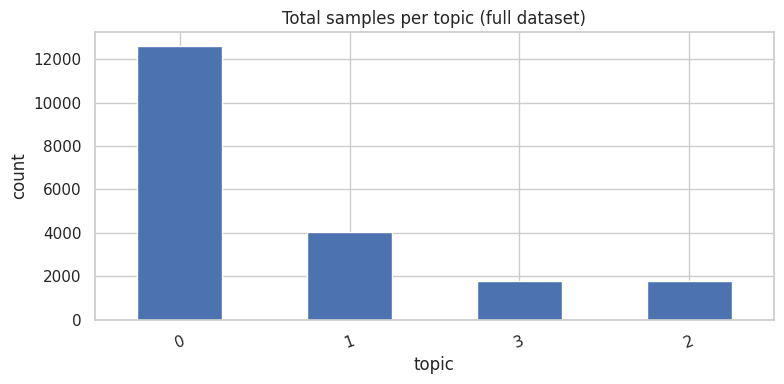

In [6]:
cts = base_df.groupby(['topic','sentiment']).size().unstack(fill_value=0)
cts['total'] = cts.sum(axis=1)
rat = cts.drop(columns=['total']).div(cts['total'], axis=0).fillna(0) * 100.0
rat = rat.round(1)
summary = cts.copy()
for col in rat.columns:
    summary[f'{col}_pct'] = rat[col]
count_cols = [c for c in cts.columns if c != 'total']
pct_cols = [f'{c}_pct' for c in count_cols]
summary = summary[['total'] + count_cols + pct_cols]
summary = summary.sort_values('total', ascending=False)

print('Overall topic-sentiment distribution (FULL dataset)')
display(summary)

plt.figure(figsize=(8,4))
summary['total'].plot(kind='bar', rot=20, title='Total samples per topic (full dataset)')
plt.xlabel('topic'); plt.ylabel('count')
plt.tight_layout(); plt.show()


# Build Pairs & Dataset


In [7]:
# ===== Build train pairs =====
def build_pairs_df(base_df, neg_per_sent=1, rng_seed=42, skip_hard_negatives=True):

    rng = random.Random(rng_seed)
    rows = []

    for _, r in base_df.iterrows():
        s = str(r["sentence"])
        t_id = int(r["topic_id"])
        y = int(r["sentiment_id"])
        t_key = ASPECTS[t_id]

        rows.append({"text": s, "aspect": t_key, "label": y + 1})

        others = [a for a in ASPECTS if a != t_key]

        s_norm = _norm_match(s)
        hard = [a for a in others if _aspect_has_kw(a, s_norm)]
        easy = [a for a in others if a not in hard]

        if skip_hard_negatives:
            picks = []


            if easy:
                n_easy = min(neg_per_sent, len(easy))
                picks.extend(rng.sample(easy, k=n_easy))

            if hard and len(picks) < neg_per_sent:
                n_hard = min(1, neg_per_sent - len(picks))
                picks.extend(rng.sample(hard, k=min(n_hard, len(hard))))
            for a in picks:
                rows.append({"text": s, "aspect": a, "label": 0})
        else:
            picks = []
            if hard:
                hard_shuf = hard[:]
                rng.shuffle(hard_shuf)
                picks.extend(hard_shuf[:neg_per_sent])
            if len(picks) < neg_per_sent and easy:
                rest = neg_per_sent - len(picks)
                picks.extend(rng.sample(easy, k=min(rest, len(easy))))

            for a in picks[:neg_per_sent]:
                rows.append({"text": s, "aspect": a, "label": 0})

    return pd.DataFrame(rows)


# ---- tokenizer ----
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=False)

def encode_pair(tokenizer, text, prompt, max_len):
    return tokenizer(
        prompt, text,
        truncation="only_second",
        padding="max_length",
        max_length=max_len,
        return_tensors="pt",
        return_overflowing_tokens=False
    )


# ---- dataset ----
class PairABSADataset(Dataset):
    def __init__(self, df_pairs, tokenizer, max_len=MAX_LEN):
        self.df = df_pairs.reset_index(drop=True)
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        s = self.df.loc[i, "text"]
        a = self.df.loc[i, "aspect"]

        prompt = _pick_subprompt(a, s)
        y = int(self.df.loc[i, "label"])
        enc = encode_pair(self.tok, s, prompt, self.max_len)

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(y, dtype=torch.long)
        return item


# ---- dataloader ----
def make_loader(df_pairs, tokenizer, batch_size=64, max_len=MAX_LEN, shuffle=True):
    ds = PairABSADataset(df_pairs, tokenizer, max_len=max_len)
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
    )


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

# Define Model & Optimizer


In [8]:
# === Model: Head 2 tầng + GELU + LayerNorm ===
class PhoBERTPairABSA(nn.Module):
    def __init__(self, base_model="vinai/phobert-base", num_cls=4, dropout=0.3):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(base_model)
        hidden_size = self.backbone.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.LayerNorm(hidden_size),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_cls)
        )

    def forward(self, input_ids, attention_mask):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        return self.classifier(cls)

model = PhoBERTPairABSA(base_model=BASE_MODEL, num_cls=4, dropout=0.3).to(device)
optimizer = AdamW([
    {"params": model.backbone.parameters(), "lr": LR_BACKBONE},
    {"params": model.classifier.parameters(), "lr": LR_HEAD},
], weight_decay=WEIGHT_DECAY)
scaler = GradScaler(enabled=(device.type == "cuda"))
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=LR_BACKBONE/10)


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

# Train

In [9]:
from sklearn.metrics import f1_score, precision_recall_fscore_support
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Prepare VAL pairs/loader once (neg_per_sent=1 for evaluation)
val_pairs_df = build_pairs_df(
    base_df=val_df[["sentence","topic_id","sentiment_id"]],
    neg_per_sent=1,
    rng_seed=SEED,
    skip_hard_negatives=True
)
val_loader = make_loader(val_pairs_df, tokenizer, batch_size=BATCH_SIZE, max_len=MAX_LEN, shuffle=False)

history = {
    'epoch': [],
    'train_loss': [], 'train_acc4': [], 'train_acc_pos3': [], 'train_macro_f1_pos3': [],
    'val_loss': [], 'val_acc4': [], 'val_acc_pos3': [], 'val_macro_f1_pos3': [],
    'none_prec': [], 'none_rec': [], 'none_f1': [],
    'val_none_prec': [], 'val_none_rec': [], 'val_none_f1': [],
}

model.train()
for epoch in range(1, NUM_EPOCHS + 1):
    # ====== Build TRAIN  ======
    neg_ps = 1 if epoch <= 4 else NEG_PER_SENT
    seed_ep = SEED + epoch

    train_pairs_df = build_pairs_df(
        base_df=train_df[["sentence","topic_id","sentiment_id"]],
        neg_per_sent=neg_ps,
        rng_seed=seed_ep,
        skip_hard_negatives=True
    )
    labels_4 = train_pairs_df["label"].values
    counts = np.bincount(labels_4, minlength=4).astype(np.int64)
    w = compute_class_weight("balanced", classes=np.arange(4), y=labels_4).astype(np.float32)

    alpha = 0.18 if epoch <= 2 else (0.15 if epoch <= 4 else 0.12)
    w0_floor = np.max(w[1:]) * alpha
    w[0] = max(w[0], w0_floor)
    print(f"\n[Epoch {epoch}] label counts (none,neg,neu,pos) = {counts.tolist()} | "
          f"class_weight = {w.round(3).tolist()} | neg_per_sent={neg_ps}")

    criterion = nn.CrossEntropyLoss(
        weight=torch.tensor(w, dtype=torch.float32, device=device),
        label_smoothing=LABEL_SMOOTH
    )

    train_loader = make_loader(
        train_pairs_df,
        tokenizer,
        batch_size=BATCH_SIZE,
        max_len=MAX_LEN,
        shuffle=True
    )

    # ====== Train one epoch ======
    running_loss = 0.0
    y_true_all, y_pred_all = [], []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}",
                leave=False, dynamic_ncols=True, file=sys.stdout)

    for batch in pbar:
        input_ids      = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels         = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", dtype=torch.float16, enabled=(device.type == "cuda")):
            logits = model(input_ids, attention_mask)
            loss   = criterion(logits, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
        scaler.step(optimizer); scaler.update()

        running_loss += loss.item()
        preds = logits.argmax(dim=1)

        y_true_all.extend(labels.cpu().tolist())
        y_pred_all.extend(preds.cpu().tolist())

        pbar.set_postfix(loss=running_loss / max(1, pbar.n))

    print("👉 Label distribution SEEN (train):", Counter(y_true_all))

    # === Train metrics ===
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    acc4 = (y_pred_all == y_true_all).mean()
    mask_pos = (y_true_all != 0)
    acc_pos3 = (y_pred_all[mask_pos] == y_true_all[mask_pos]).mean() if mask_pos.any() else 0.0
    macro_f1_pos3 = f1_score(y_true_all[mask_pos], y_pred_all[mask_pos],
                             average="macro", labels=[1,2,3]) if mask_pos.any() else 0.0

    y_true_none = (y_true_all == 0).astype(int)
    y_pred_none = (y_pred_all == 0).astype(int)
    none_prec, none_rec, none_f1, _ = precision_recall_fscore_support(
        y_true_none, y_pred_none, average="binary", zero_division=0
    )

    avg_loss = running_loss / len(train_loader)

    # ====== Validation ======
    model.eval()
    val_running_loss = 0.0
    y_true_val, y_pred_val = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            labels         = batch["labels"].to(device, non_blocking=True)

            logits = model(input_ids, attention_mask)
            loss   = criterion(logits, labels)
            val_running_loss += loss.item()

            preds = logits.argmax(dim=1)
            y_true_val.extend(labels.cpu().tolist())
            y_pred_val.extend(preds.cpu().tolist())

    y_true_val = np.array(y_true_val)
    y_pred_val = np.array(y_pred_val)

    val_acc4 = (y_pred_val == y_true_val).mean()
    mask_pos_v = (y_true_val != 0)
    val_acc_pos3 = (y_pred_val[mask_pos_v] == y_true_val[mask_pos_v]).mean() if mask_pos_v.any() else 0.0
    val_macro_f1_pos3 = f1_score(y_true_val[mask_pos_v], y_pred_val[mask_pos_v],
                                 average="macro", labels=[1,2,3]) if mask_pos_v.any() else 0.0

    y_true_none_v = (y_true_val == 0).astype(int)
    y_pred_none_v = (y_pred_val == 0).astype(int)
    val_none_prec, val_none_rec, val_none_f1, _ = precision_recall_fscore_support(
        y_true_none_v, y_pred_none_v, average="binary", zero_division=0
    )

    val_avg_loss = val_running_loss / max(1, len(val_loader))

    # ====== Logging ======
    print(
        f"\n✅ Epoch {epoch}/{NUM_EPOCHS} | "
        f"TrainLoss={avg_loss:.4f} | Acc4={acc4:.4f} | Acc_pos3={acc_pos3:.4f} | MacroF1_pos3={macro_f1_pos3:.4f} | "
        f"None(P/R/F1)={none_prec:.3f}/{none_rec:.3f}/{none_f1:.3f}\n"
        f"   ValLoss={val_avg_loss:.4f}  | ValAcc4={val_acc4:.4f} | ValAcc_pos3={val_acc_pos3:.4f} | ValMacroF1_pos3={val_macro_f1_pos3:.4f} | "
        f"ValNone(P/R/F1)={val_none_prec:.3f}/{val_none_rec:.3f}/{val_none_f1:.3f}"
    )

    history['epoch'].append(epoch)
    history['train_loss'].append(avg_loss); history['train_acc4'].append(acc4)
    history['train_acc_pos3'].append(acc_pos3); history['train_macro_f1_pos3'].append(macro_f1_pos3)
    history['none_prec'].append(none_prec); history['none_rec'].append(none_rec); history['none_f1'].append(none_f1)
    history['val_loss'].append(val_avg_loss); history['val_acc4'].append(val_acc4)
    history['val_acc_pos3'].append(val_acc_pos3); history['val_macro_f1_pos3'].append(val_macro_f1_pos3)
    history['val_none_prec'].append(val_none_prec); history['val_none_rec'].append(val_none_rec); history['val_none_f1'].append(val_none_f1)

    model.train()
    scheduler.step()

print("\n🎉 Training completed.")



[Epoch 1] label counts (none,neg,neu,pos) = [14154, 6331, 1051, 6772] | class_weight = [1.2120000123977661, 1.1180000305175781, 6.734000205993652, 1.0449999570846558] | neg_per_sent=1


Epoch 1/8:   0%|          | 0/443 [00:00<?, ?it/s]

👉 Label distribution SEEN (train): Counter({0: 14154, 3: 6772, 1: 6331, 2: 1051})

✅ Epoch 1/8 | TrainLoss=1.0760 | Acc4=0.7169 | Acc_pos3=0.5731 | MacroF1_pos3=0.5651 | None(P/R/F1)=0.808/0.861/0.834
   ValLoss=0.9060  | ValAcc4=0.8479 | ValAcc_pos3=0.7584 | ValMacroF1_pos3=0.7645 | ValNone(P/R/F1)=0.839/0.937/0.886

[Epoch 2] label counts (none,neg,neu,pos) = [14154, 6331, 1051, 6772] | class_weight = [1.2120000123977661, 1.1180000305175781, 6.734000205993652, 1.0449999570846558] | neg_per_sent=1


Epoch 2/8:   0%|          | 0/443 [00:00<?, ?it/s]

👉 Label distribution SEEN (train): Counter({0: 14154, 3: 6772, 1: 6331, 2: 1051})

✅ Epoch 2/8 | TrainLoss=0.8777 | Acc4=0.8380 | Acc_pos3=0.7687 | MacroF1_pos3=0.7662 | None(P/R/F1)=0.861/0.907/0.883
   ValLoss=0.8316  | ValAcc4=0.8790 | ValAcc_pos3=0.8055 | ValMacroF1_pos3=0.8105 | ValNone(P/R/F1)=0.868/0.953/0.908

[Epoch 3] label counts (none,neg,neu,pos) = [14154, 6331, 1051, 6772] | class_weight = [1.0099999904632568, 1.1180000305175781, 6.734000205993652, 1.0449999570846558] | neg_per_sent=1


Epoch 3/8:   0%|          | 0/443 [00:00<?, ?it/s]

👉 Label distribution SEEN (train): Counter({0: 14154, 3: 6772, 1: 6331, 2: 1051})

✅ Epoch 3/8 | TrainLoss=0.8363 | Acc4=0.8746 | Acc_pos3=0.8359 | MacroF1_pos3=0.8302 | None(P/R/F1)=0.900/0.913/0.907
   ValLoss=0.8263  | ValAcc4=0.8821 | ValAcc_pos3=0.8492 | ValMacroF1_pos3=0.8352 | ValNone(P/R/F1)=0.914/0.915/0.914

[Epoch 4] label counts (none,neg,neu,pos) = [14154, 6331, 1051, 6772] | class_weight = [1.0099999904632568, 1.1180000305175781, 6.734000205993652, 1.0449999570846558] | neg_per_sent=1


Epoch 4/8:   0%|          | 0/443 [00:00<?, ?it/s]

👉 Label distribution SEEN (train): Counter({0: 14154, 3: 6772, 1: 6331, 2: 1051})

✅ Epoch 4/8 | TrainLoss=0.7887 | Acc4=0.8970 | Acc_pos3=0.8690 | MacroF1_pos3=0.8662 | None(P/R/F1)=0.920/0.925/0.922
   ValLoss=0.8255  | ValAcc4=0.8931 | ValAcc_pos3=0.8367 | ValMacroF1_pos3=0.8296 | ValNone(P/R/F1)=0.901/0.950/0.925

[Epoch 5] label counts (none,neg,neu,pos) = [28304, 6331, 1051, 6772] | class_weight = [1.2120000123977661, 1.6770000457763672, 10.098999977111816, 1.5670000314712524] | neg_per_sent=2


Epoch 5/8:   0%|          | 0/664 [00:00<?, ?it/s]

👉 Label distribution SEEN (train): Counter({0: 28304, 3: 6772, 1: 6331, 2: 1051})

✅ Epoch 5/8 | TrainLoss=0.8507 | Acc4=0.9187 | Acc_pos3=0.8716 | MacroF1_pos3=0.8803 | None(P/R/F1)=0.955/0.942/0.949
   ValLoss=0.8342  | ValAcc4=0.9102 | ValAcc_pos3=0.8670 | ValMacroF1_pos3=0.8548 | ValNone(P/R/F1)=0.922/0.953/0.938

[Epoch 6] label counts (none,neg,neu,pos) = [28304, 6331, 1051, 6772] | class_weight = [1.2120000123977661, 1.6770000457763672, 10.098999977111816, 1.5670000314712524] | neg_per_sent=2


Epoch 6/8:   0%|          | 0/664 [00:00<?, ?it/s]

👉 Label distribution SEEN (train): Counter({0: 28304, 3: 6772, 1: 6331, 2: 1051})

✅ Epoch 6/8 | TrainLoss=0.8255 | Acc4=0.9283 | Acc_pos3=0.8879 | MacroF1_pos3=0.8934 | None(P/R/F1)=0.961/0.948/0.955
   ValLoss=0.8624  | ValAcc4=0.9100 | ValAcc_pos3=0.8490 | ValMacroF1_pos3=0.8420 | ValNone(P/R/F1)=0.904/0.971/0.936

[Epoch 7] label counts (none,neg,neu,pos) = [28304, 6331, 1051, 6772] | class_weight = [1.2120000123977661, 1.6770000457763672, 10.098999977111816, 1.5670000314712524] | neg_per_sent=2


Epoch 7/8:   0%|          | 0/664 [00:00<?, ?it/s]

👉 Label distribution SEEN (train): Counter({0: 28304, 3: 6772, 1: 6331, 2: 1051})

✅ Epoch 7/8 | TrainLoss=0.8140 | Acc4=0.9350 | Acc_pos3=0.8986 | MacroF1_pos3=0.9078 | None(P/R/F1)=0.964/0.953/0.959
   ValLoss=0.8405  | ValAcc4=0.9164 | ValAcc_pos3=0.8660 | ValMacroF1_pos3=0.8540 | ValNone(P/R/F1)=0.920/0.967/0.943

[Epoch 8] label counts (none,neg,neu,pos) = [28304, 6331, 1051, 6772] | class_weight = [1.2120000123977661, 1.6770000457763672, 10.098999977111816, 1.5670000314712524] | neg_per_sent=2


Epoch 8/8:   0%|          | 0/664 [00:00<?, ?it/s]

👉 Label distribution SEEN (train): Counter({0: 28304, 3: 6772, 1: 6331, 2: 1051})

✅ Epoch 8/8 | TrainLoss=0.8097 | Acc4=0.9365 | Acc_pos3=0.9017 | MacroF1_pos3=0.9102 | None(P/R/F1)=0.966/0.954/0.960
   ValLoss=0.8453  | ValAcc4=0.9160 | ValAcc_pos3=0.8625 | ValMacroF1_pos3=0.8526 | ValNone(P/R/F1)=0.916/0.970/0.942

🎉 Training completed.


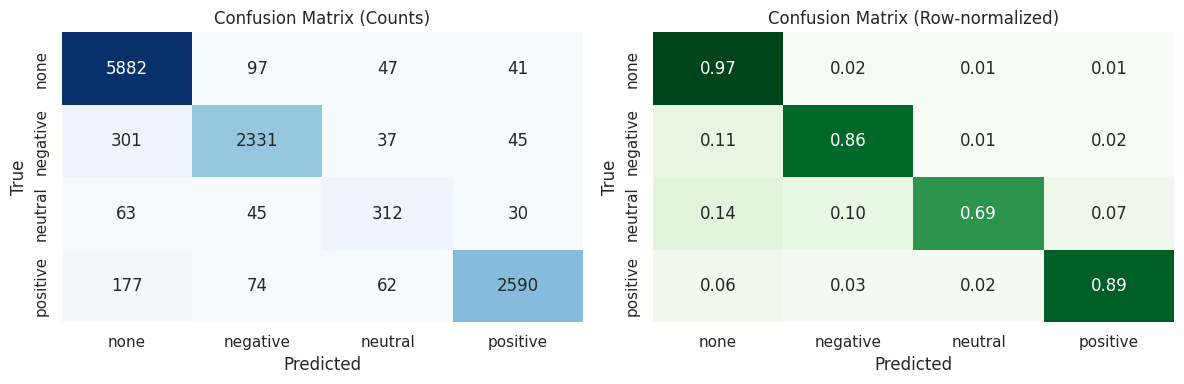

,class,precision,recall,f1,support
0,none,0.916,0.970,0.942,6067
1,negative,0.915,0.859,0.886,2714
2,neutral,0.681,0.693,0.687,450
3,positive,0.957,0.892,0.924,2903


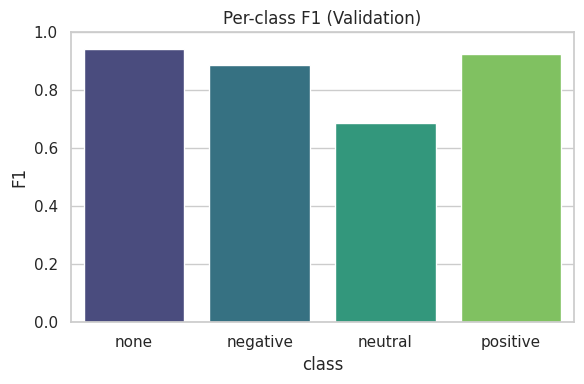

,aspect,support_pos,macro_f1_pos3
1,co_so_vat_chat,533,0.887
2,giang_vien,3782,0.850
0,chuong_trinh,1211,0.803
3,khac,541,0.692


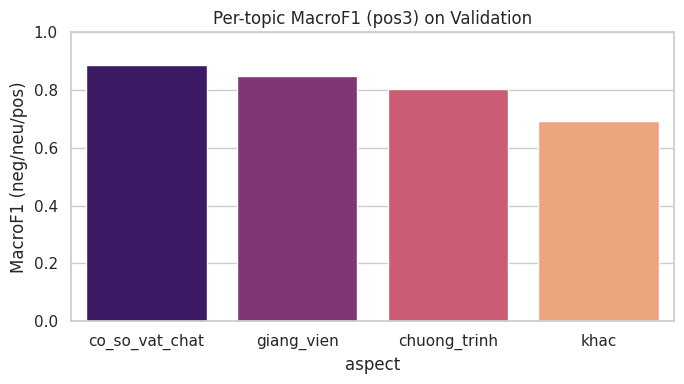

In [10]:
# === Validation Confusion Matrix, Per-class F1, and Per-topic MacroF1 ===
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

# Recompute validation predictions with final model
model.eval()
y_true_v, y_pred_v = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids      = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels         = batch["labels"].to(device, non_blocking=True)

        logits = model(input_ids, attention_mask)
        preds  = logits.argmax(dim=1)

        y_true_v.extend(labels.cpu().tolist())
        y_pred_v.extend(preds.cpu().tolist())

y_true_v = np.array(y_true_v)
y_pred_v = np.array(y_pred_v)

# 1) Confusion matrix (4-class)
cls_labels = [0,1,2,3]
cls_names  = ['none','negative','neutral','positive']
cm = confusion_matrix(y_true_v, y_pred_v, labels=cls_labels)
cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(min=1)

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=cls_names, yticklabels=cls_names)
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', cbar=False, ax=axes[1],
            xticklabels=cls_names, yticklabels=cls_names)
axes[1].set_title('Confusion Matrix (Row-normalized)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
plt.tight_layout(); plt.show()

# 2) Per-class metrics
prec, rec, f1, support = precision_recall_fscore_support(
    y_true_v, y_pred_v, labels=cls_labels, zero_division=0
)
per_class_df = pd.DataFrame({
    'class': cls_names,
    'precision': prec.round(3),
    'recall': rec.round(3),
    'f1': f1.round(3),
    'support': support.astype(int),
})
display(per_class_df)

plt.figure(figsize=(6,4))
sns.barplot(x='class', y='f1', data=per_class_df, palette='viridis')
plt.title('Per-class F1 (Validation)'); plt.xlabel('class'); plt.ylabel('F1')
plt.ylim(0,1.0); plt.tight_layout(); plt.show()

# 3) Per-topic MacroF1 on pos3 (neg/neu/pos) using val_pairs_df alignment
#    DataLoader was created with shuffle=False, so indices align with val_pairs_df order
val_aspects = val_pairs_df['aspect'].values
rows = []
for asp in sorted(pd.unique(val_aspects)):
    mask_asp = (val_aspects == asp)
    y_t = y_true_v[mask_asp]
    y_p = y_pred_v[mask_asp]
    # Only consider pos3 (labels 1,2,3)
    mask_pos = (y_t != 0)
    support_pos = int(mask_pos.sum())
    if support_pos > 0:
        f1_pos3 = f1_score(y_t[mask_pos], y_p[mask_pos], average='macro', labels=[1,2,3])
    else:
        f1_pos3 = np.nan
    rows.append({'aspect': asp, 'support_pos': support_pos, 'macro_f1_pos3': None if np.isnan(f1_pos3) else round(float(f1_pos3), 3)})

per_topic_df = pd.DataFrame(rows).sort_values(['macro_f1_pos3','support_pos'], ascending=[False, False])
display(per_topic_df)

plt.figure(figsize=(7,4))
sns.barplot(x='aspect', y='macro_f1_pos3', data=per_topic_df, palette='magma')
plt.title('Per-topic MacroF1 (pos3) on Validation')
plt.ylim(0,1.0); plt.xlabel('aspect'); plt.ylabel('MacroF1 (neg/neu/pos)')
plt.tight_layout(); plt.show()


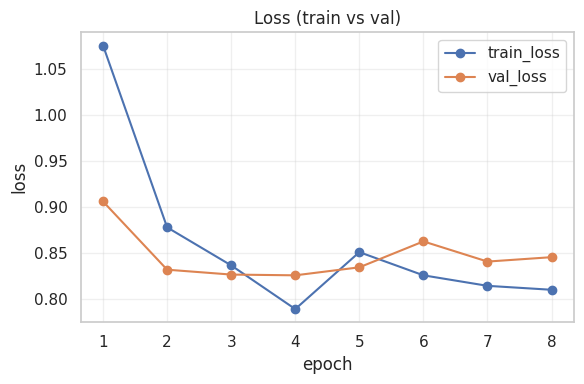

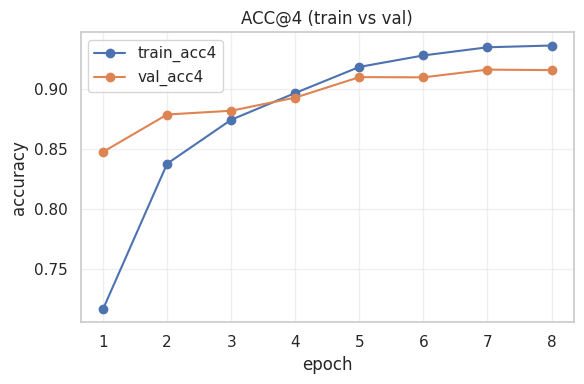

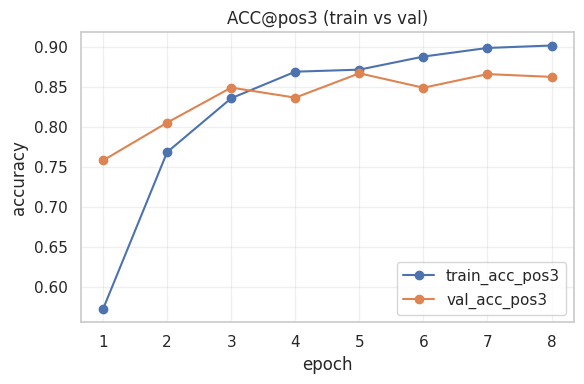

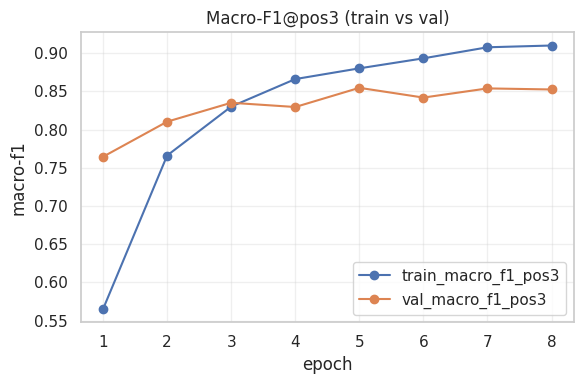

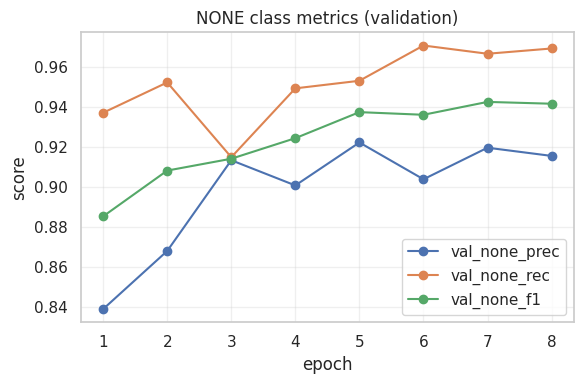

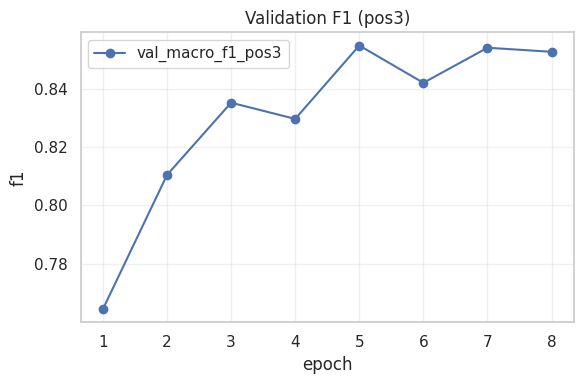

In [11]:
# === Plot training/validation metrics across epochs ===
# Expects a dict `history` with keys like:
# 'train_loss', 'val_loss', 'train_acc4', 'val_acc4', 'train_acc_pos3', 'val_acc_pos3', 'train_macro_f1_pos3', 'val_macro_f1_pos3', ...

# Build DataFrame from history
if 'history' not in globals():
    raise RuntimeError("Không tìm thấy biến 'history'. Hãy chạy lại ô train để ghi history theo epoch.")

hist_df = pd.DataFrame(history)
# Epoch index starting at 1 for nicer x-axis
hist_df.index = np.arange(1, len(hist_df) + 1)

# Helper to plot pairs (train/val) if available
def plot_pair(df, k_train, k_val, title, ylabel):
    has_train = k_train in df.columns
    has_val   = k_val in df.columns
    if not (has_train or has_val):
        return False
    plt.figure(figsize=(6,4))
    if has_train:
        plt.plot(df.index, df[k_train], label=k_train, marker='o')
    if has_val:
        plt.plot(df.index, df[k_val], label=k_val, marker='o')
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return True

# Helper to plot any available single/multi keys together (val-only metrics etc.)
def plot_keys(df, keys, title, ylabel):
    keys = [k for k in keys if k in df.columns]
    if not keys:
        return False
    plt.figure(figsize=(6,4))
    for k in keys:
        plt.plot(df.index, df[k], label=k, marker='o')
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return True

# Core metrics
_ = plot_pair(hist_df, 'train_loss', 'val_loss', 'Loss (train vs val)', 'loss')
_ = plot_pair(hist_df, 'train_acc4', 'val_acc4', 'ACC@4 (train vs val)', 'accuracy')
_ = plot_pair(hist_df, 'train_acc_pos3', 'val_acc_pos3', 'ACC@pos3 (train vs val)', 'accuracy')
_ = plot_pair(hist_df, 'train_macro_f1_pos3', 'val_macro_f1_pos3', 'Macro-F1@pos3 (train vs val)', 'macro-f1')

# Optional: any additional metrics that exist in history (val-only none metrics, etc.)
_ = plot_keys(hist_df, ['val_none_prec','val_none_rec','val_none_f1'], 'NONE class metrics (validation)', 'score')
_ = plot_keys(hist_df, ['val_micro_f1_pos3','val_macro_f1_pos3'], 'Validation F1 (pos3)', 'f1')
_ = plot_keys(hist_df, ['lr'], 'Learning rate', 'lr')
